In [3]:
import serial
import serial.tools.list_ports
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

C:\Users\dcaka\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
ports = serial.tools.list_ports.comports()
for port, desc, hwid in sorted(ports):
    print("{}: {} [{}]".format(port, desc, hwid))

COM4: USB-SERIAL CH340 (COM4) [USB VID:PID=1A86:7523 SER= LOCATION=1-2]


In [15]:
# Run once at the beginning of test
rssi_1s = []
rssi_2s = []
idx = 0

<IPython.core.display.Javascript object>


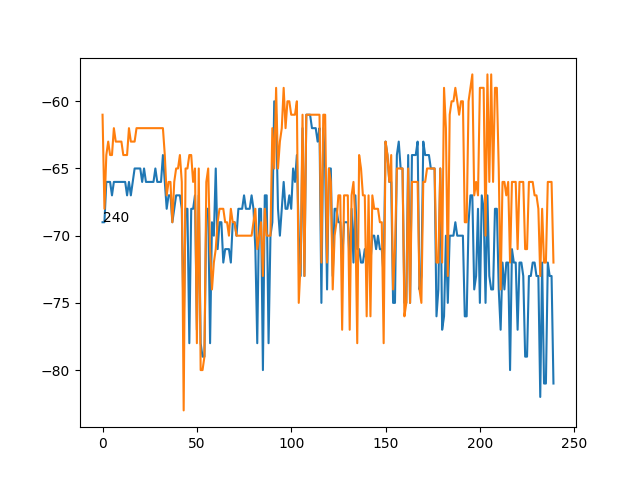

KeyboardInterrupt: 

In [25]:
%matplotlib notebook

with serial.Serial('COM4', 9600) as ser:
    line = ""
    first_esp = True
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()
    
    fig.show()
    fig.canvas.draw()
    
    while True:
        try:
            bytes_to_read = ser.inWaiting()
        except IOError:
            raise IOError()
        if bytes_to_read:
            line = line + ser.read(bytes_to_read).decode("utf-8")
            if "\r\n" in line:
                lines = line.split("\r\n")
                if len(lines) > 4:
                    if not "nan" in lines:
                        rssi_1s.append(float(lines[1]))
                        rssi_2s.append(float(lines[3]))
                        idx += 1
                        ax.clear()
                        ax.plot(range(idx), rssi_1s, label='RSSI 1')
                        ax.plot(range(idx), rssi_2s, label='RSSI 2')
                        plt.text(0, rssi_1s[0], idx)
                        ax.relim()
                        ax.autoscale_view()
                        fig.canvas.draw()
                    
                    line = ""

In [26]:
# Saving test data

import pandas as pd
import matplotlib.pyplot as plt
rssi_1_vals = np.asarray(rssi_1s).reshape(-1, 1)
rssi_2_vals = np.asarray(rssi_2s).reshape(-1, 1)
data = np.concatenate((rssi_1_vals, rssi_2_vals), axis=1)
print(data)
df = pd.DataFrame(data)
df.to_csv("rssi_directional_test_.csv")

[[-69. -61.]
 [-69. -68.]
 [-66. -64.]
 [-66. -63.]
 [-66. -64.]
 [-67. -64.]
 [-66. -62.]
 [-66. -63.]
 [-66. -63.]
 [-66. -63.]
 [-66. -63.]
 [-66. -64.]
 [-66. -64.]
 [-67. -64.]
 [-66. -62.]
 [-67. -63.]
 [-66. -63.]
 [-65. -63.]
 [-65. -62.]
 [-65. -62.]
 [-65. -62.]
 [-66. -62.]
 [-65. -62.]
 [-66. -62.]
 [-66. -62.]
 [-66. -62.]
 [-66. -62.]
 [-66. -62.]
 [-65. -62.]
 [-66. -62.]
 [-66. -62.]
 [-66. -62.]
 [-64. -62.]
 [-66. -64.]
 [-68. -67.]
 [-67. -66.]
 [-67. -66.]
 [-69. -69.]
 [-68. -66.]
 [-67. -65.]
 [-67. -65.]
 [-67. -64.]
 [-68. -66.]
 [-77. -83.]
 [-68. -65.]
 [-68. -65.]
 [-78. -64.]
 [-68. -64.]
 [-68. -66.]
 [-67. -65.]
 [-77. -78.]
 [-67. -65.]
 [-78. -80.]
 [-79. -80.]
 [-79. -79.]
 [-68. -66.]
 [-68. -65.]
 [-78. -71.]
 [-69. -74.]
 [-70. -72.]
 [-65. -71.]
 [-71. -69.]
 [-69. -68.]
 [-69. -68.]
 [-72. -68.]
 [-71. -69.]
 [-71. -69.]
 [-71. -70.]
 [-72. -68.]
 [-69. -69.]
 [-69. -69.]
 [-70. -70.]
 [-68. -70.]
 [-68. -70.]
 [-68. -70.]
 [-67. -70.]
 [-68. -70.]

<IPython.core.display.Javascript object>


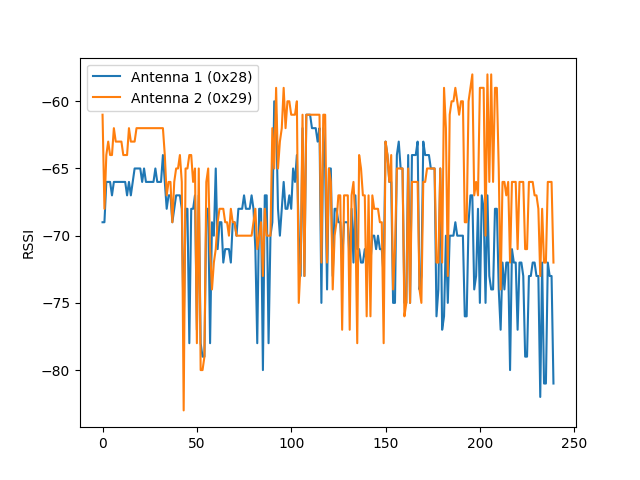

In [59]:
# Reading test data
df1 = pd.read_csv("rssi_directional_test_25m_good.csv")
plt.figure()
df1['0'].plot(label='Antenna 1 (0x28)')
df1['1'].plot(label='Antenna 2 (0x29)')
plt.ylabel("RSSI")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


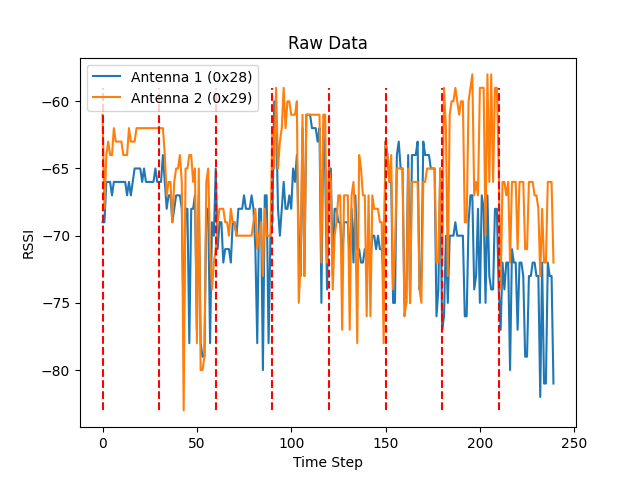

<IPython.core.display.Javascript object>


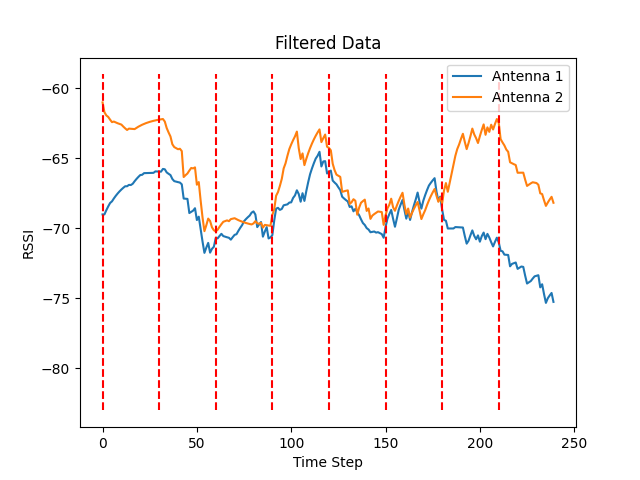

<IPython.core.display.Javascript object>


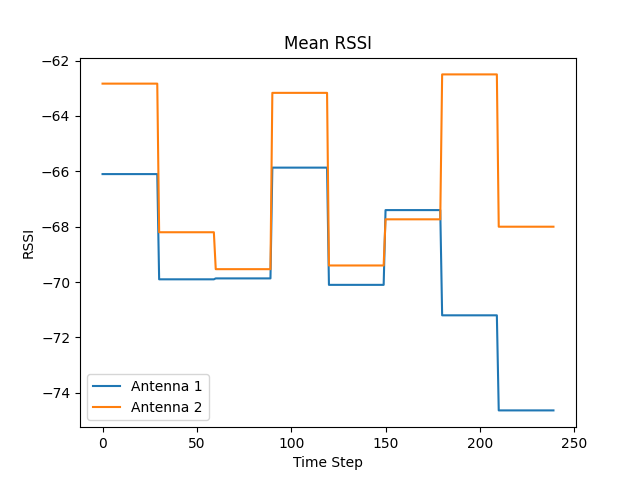

<IPython.core.display.Javascript object>


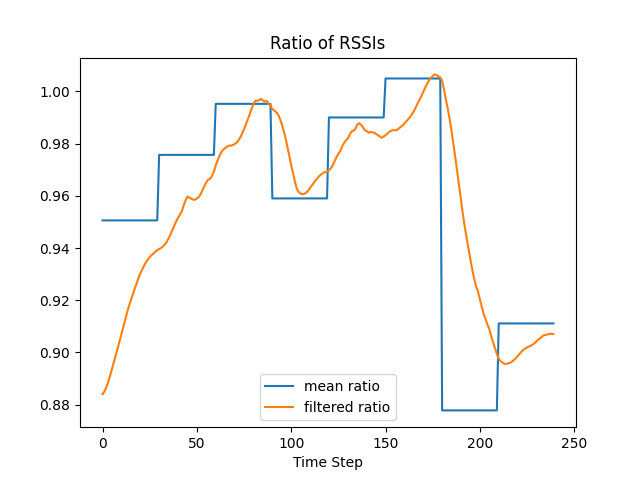

In [100]:
# Plotting/Analyzing test data

df1 = pd.read_csv("rssi_directional_test_25m_good.csv")

r1s = df1['0'].values
r2s = df1['1'].values
filtered_r1s = r1s.copy()
filtered_r2s = r2s.copy()
sig = 0.1
for i in range(r1s.size):
    if i == 0:
        continue
    else:
        filtered_r1s[i] = filtered_r1s[i-1] * (1 - sig) + r1s[i] * sig
        filtered_r2s[i] = filtered_r2s[i-1] * (1 - sig) + r2s[i] * sig
        
min_rssi = df1.to_numpy()[:, 1:3].min()
max_rssi = df1.to_numpy()[:, 1:3].max()
pos_s = np.arange(min_rssi, max_rssi)
xs_s = np.zeros((pos_s.size, 8))
for i in range(8):
    xs_s[:, i] = np.ones_like(pos_s) * 30 * i

plt.figure()
df1['0'].plot(label='Antenna 1 (0x28)')
df1['1'].plot(label='Antenna 2 (0x29)')
for i in range(8):
    plt.plot(xs_s[:, i], pos_s, 'r--')
plt.ylabel("RSSI")
plt.xlabel("Time Step")
plt.title("Raw Data")
plt.legend()
plt.show()       
    
x = range(filtered_r1s.size)
plt.figure()
plt.plot(x, filtered_r1s, label='Antenna 1')
plt.plot(x, filtered_r2s, label='Antenna 2')
for i in range(8):
    plt.plot(xs_s[:, i], pos_s, 'r--')
plt.ylabel("RSSI")
plt.xlabel("Time Step")
plt.title("Filtered Data")
plt.legend()
plt.show()

mean_r1s = r1s.copy()
mean_r2s = r2s.copy()

for i in range(8):
    mean_r1s[30*i:30*i + 30] = np.mean(r1s[30*i:30*i + 30])
    mean_r2s[30*i:30*i + 30] = np.mean(r2s[30*i:30*i + 30]) 
    
plt.figure()
plt.plot(x, mean_r1s, label='Antenna 1')
plt.plot(x, mean_r2s, label='Antenna 2')
plt.ylabel("RSSI")
plt.xlabel("Time Step")
plt.title("Mean RSSI")
plt.legend()
plt.show()

ratio = np.divide(filtered_r2s, filtered_r1s)
mean_ratio = np.divide(mean_r2s, mean_r1s)
# plt.figure()
# plt.plot(x, ratio)
# plt.show()

filtered_ratio = ratio.copy()
ratio_sig = 0.1
for i in range(filtered_ratio.size):
    if i == 0:
        continue
    filtered_ratio[i] = filtered_ratio[i-1] * (1 - ratio_sig) + ratio[i] * ratio_sig
    
plt.figure()
plt.plot(x, mean_ratio, label='mean ratio')
plt.plot(x, filtered_ratio, label='filtered ratio')
plt.xlabel("Time Step")
plt.legend()
plt.title("Ratio of RSSIs")
plt.show()

<IPython.core.display.Javascript object>


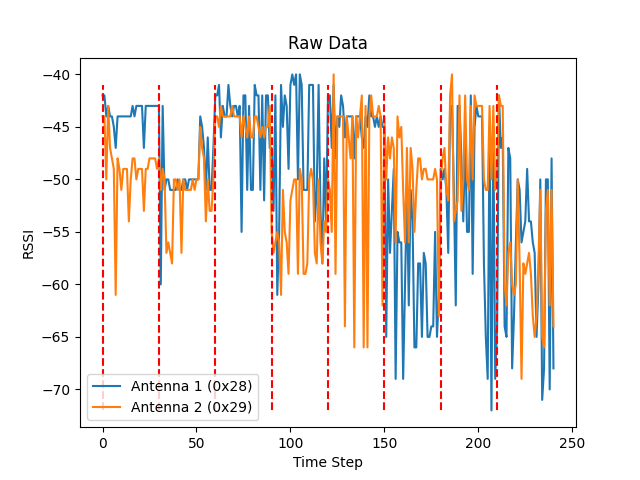

<IPython.core.display.Javascript object>


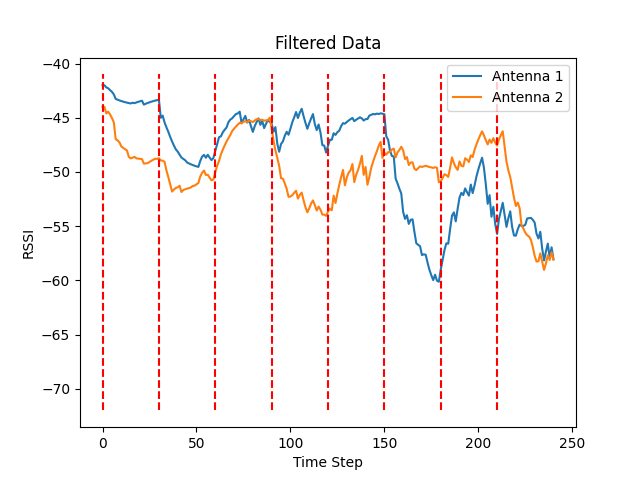

<IPython.core.display.Javascript object>


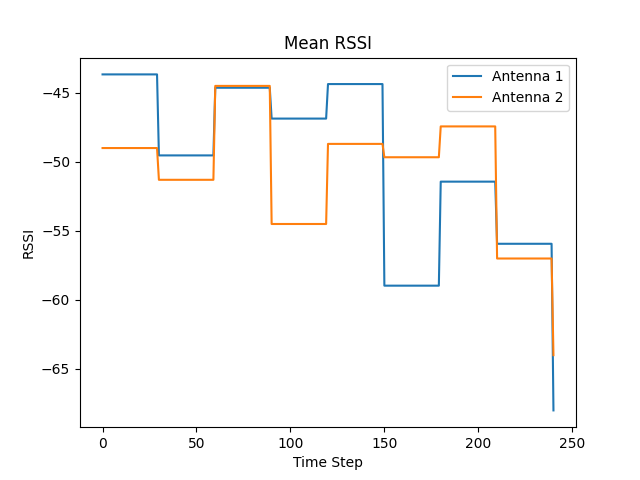

<IPython.core.display.Javascript object>


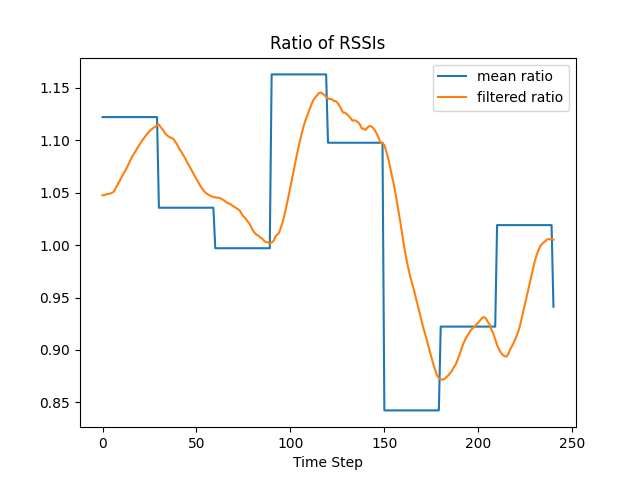

In [99]:
df1 = pd.read_csv("rssi_directional_test_5m_edited.csv")

r1s = df1['0'].values
r2s = df1['1'].values
filtered_r1s = r1s.copy()
filtered_r2s = r2s.copy()
sig = 0.1
for i in range(r1s.size):
    if i == 0:
        continue
    else:
        filtered_r1s[i] = filtered_r1s[i-1] * (1 - sig) + r1s[i] * sig
        filtered_r2s[i] = filtered_r2s[i-1] * (1 - sig) + r2s[i] * sig
        
min_rssi = df1.to_numpy()[:, 1:3].min()
max_rssi = df1.to_numpy()[:, 1:3].max()
pos_s = np.arange(min_rssi, max_rssi)
xs_s = np.zeros((pos_s.size, 8))
for i in range(8):
    xs_s[:, i] = np.ones_like(pos_s) * 30 * i

plt.figure()
df1['0'].plot(label='Antenna 1 (0x28)')
df1['1'].plot(label='Antenna 2 (0x29)')
for i in range(8):
    plt.plot(xs_s[:, i], pos_s, 'r--')
plt.ylabel("RSSI")
plt.xlabel("Time Step")
plt.title("Raw Data")
plt.legend()
plt.show()       
    
x = range(filtered_r1s.size)
plt.figure()
plt.plot(x, filtered_r1s, label='Antenna 1')
plt.plot(x, filtered_r2s, label='Antenna 2')
for i in range(8):
    plt.plot(xs_s[:, i], pos_s, 'r--')
plt.ylabel("RSSI")
plt.xlabel("Time Step")
plt.title("Filtered Data")
plt.legend()
plt.show()

mean_r1s = r1s.copy()
mean_r2s = r2s.copy()

for i in range(8):
    mean_r1s[30*i:30*i + 30] = np.mean(r1s[30*i:30*i + 30])
    mean_r2s[30*i:30*i + 30] = np.mean(r2s[30*i:30*i + 30]) 
    
plt.figure()
plt.plot(x, mean_r1s, label='Antenna 1')
plt.plot(x, mean_r2s, label='Antenna 2')
plt.ylabel("RSSI")
plt.xlabel("Time Step")
plt.title("Mean RSSI")
plt.legend()
plt.show()

ratio = np.divide(filtered_r2s, filtered_r1s)
mean_ratio = np.divide(mean_r2s, mean_r1s)

filtered_ratio = ratio.copy()
ratio_sig = 0.1
for i in range(filtered_ratio.size):
    if i == 0:
        continue
    filtered_ratio[i] = filtered_ratio[i-1] * (1 - ratio_sig) + ratio[i] * ratio_sig
    
plt.figure()
plt.plot(x, mean_ratio, label='mean ratio')
plt.plot(x, filtered_ratio, label='filtered ratio')
plt.xlabel("Time Step")
plt.legend()
plt.title("Ratio of RSSIs")
plt.show()